<a href="https://colab.research.google.com/github/doo52oh/KaggleStudy/blob/master/Binary_clf_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [109]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from datetime import datetime

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel
from sklearn.utils import shuffle

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, Lasso

pd.set_option('display.max_columns', 100)


import warnings
warnings.filterwarnings("ignore")

In [111]:
!rm *.*
!kaggle competitions download -c titanic
!unzip '*.zip'

  0% 0.00/59.8k [00:00<?, ?B/s]
100% 59.8k/59.8k [00:00<00:00, 22.3MB/s]
  0% 0.00/3.18k [00:00<?, ?B/s]
100% 3.18k/3.18k [00:00<00:00, 9.10MB/s]
  0% 0.00/28.0k [00:00<?, ?B/s]
100% 28.0k/28.0k [00:00<00:00, 23.0MB/s]
unzip:  cannot find or open *.zip, *.zip.zip or *.zip.ZIP.

No zipfiles found.


In [112]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sub = pd.read_csv('gender_submission.csv')

In [113]:
print(train.shape)
train.head()

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [114]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [115]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [116]:
print(test.shape)
test.head()

(418, 11)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [117]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [118]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

# EDA

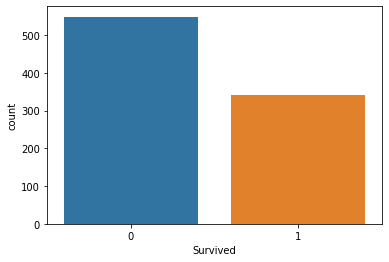

In [119]:
sns.countplot(x='Survived', data = train)

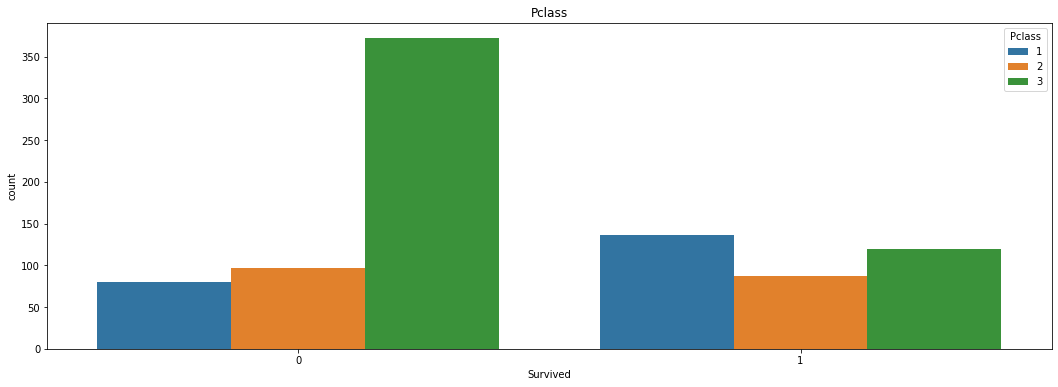

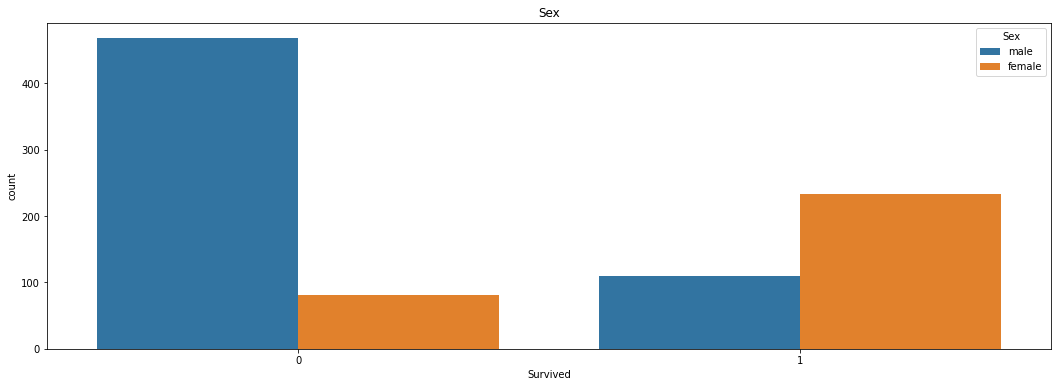

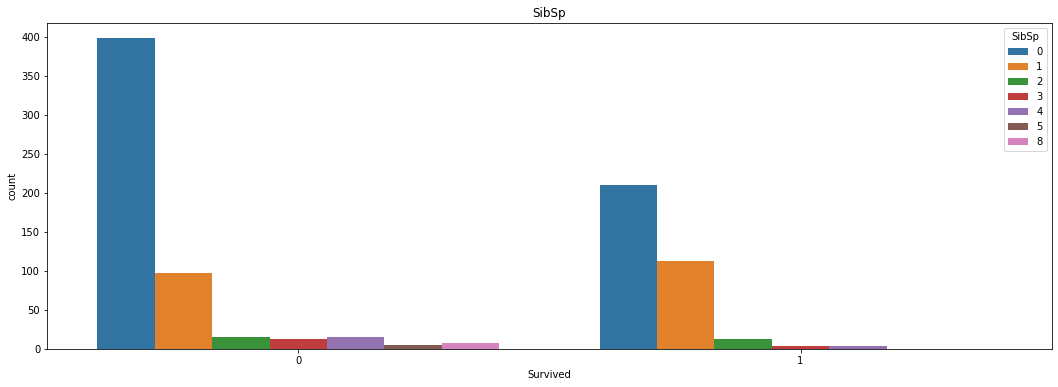

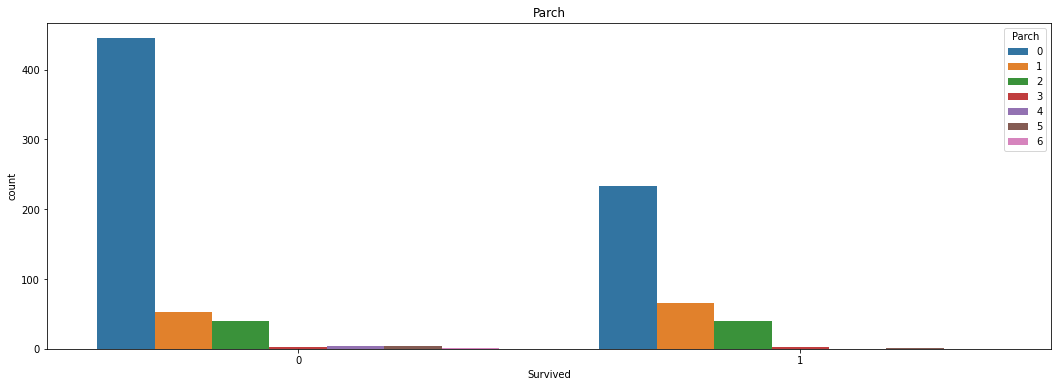

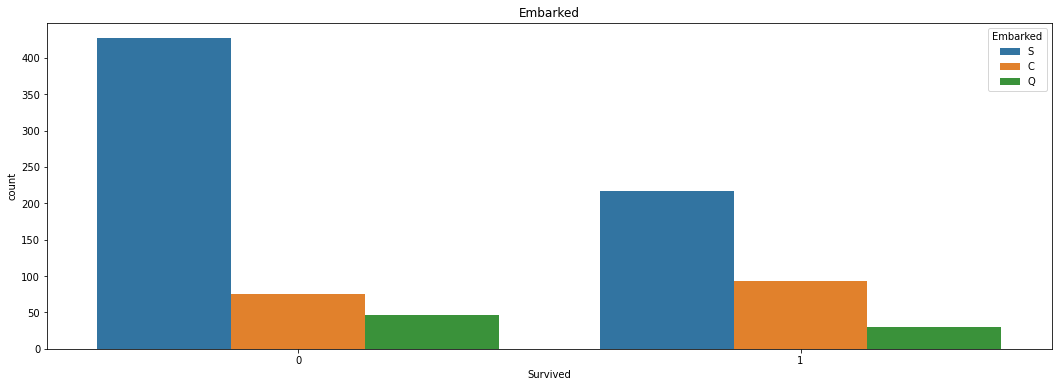

In [120]:
cat = ['Pclass','Sex','SibSp','Parch','Embarked']

for c in cat:
  fig, ax = plt.subplots(figsize=(18,6))

  sns.countplot(x='Survived', hue = c, data = train, ax = ax)
  plt.title(c)

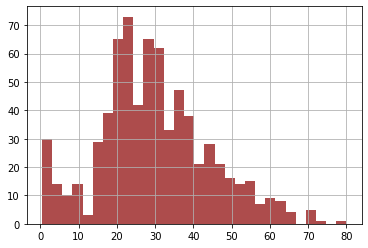

In [121]:
train['Age'].hist(bins=30,color='darkred',alpha=0.7)

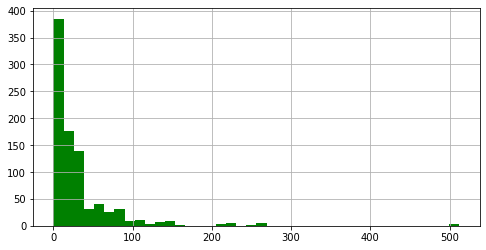

In [122]:
train['Fare'].hist(color='green',bins=40,figsize=(8,4))

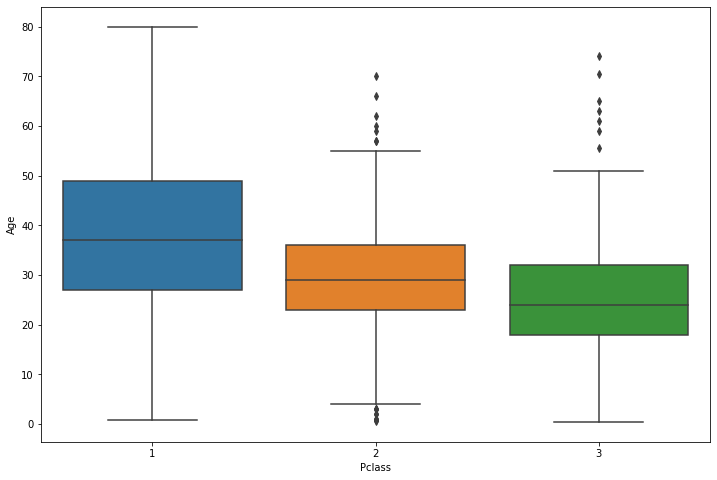

In [123]:
plt.figure(figsize = (12,8))
sns.boxplot(x='Pclass', y ='Age', data = train)

In [124]:
train['Age'].groupby(train.Pclass).mean()

Pclass
1    38.233441
2    29.877630
3    25.140620
Name: Age, dtype: float64

In [125]:
def impute_age(c):
  Age = c[0]
  Pclass = c[1]

  if pd.isnull(Age):
    if Pclass == 1:
      return 38.2
    elif Pclass == 2:
      return 29.8
    elif Pclass == 3:
      return 25
  else:
      return Age

train['Age'] = train[['Age','Pclass']].apply(impute_age, axis = 1)
test['Age'] = test[['Age','Pclass']].apply(impute_age, axis = 1)


In [126]:
train['Age'].isnull().sum()

0

In [127]:
test['Age'].isnull().sum()

0

In [128]:
train['Embarked'] = train['Embarked'].fillna('S')
test['Embarked'] = test['Embarked'].fillna('S')

In [129]:
train.drop('Cabin',axis=1,inplace=True)
test.drop('Cabin',axis = 1, inplace =True)

In [130]:
train.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

In [131]:
test.isna().sum()

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           1
Embarked       0
dtype: int64

In [132]:
test['Fare'].fillna(0, inplace = True)

# Preprocessing

In [133]:
train.drop(['Name','Ticket'], axis = 1, inplace = True)
test.drop(['Name','Ticket'], axis = 1, inplace = True)

In [134]:
train.shape, test.shape

((891, 9), (418, 8))

In [135]:
train = train.set_index('PassengerId')
test = test.set_index('PassengerId')

In [136]:
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S
2,1,1,female,38.0,1,0,71.2833,C
3,1,3,female,26.0,0,0,7.9250,S
4,1,1,female,35.0,1,0,53.1000,S
5,0,3,male,35.0,0,0,8.0500,S


In [137]:
test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,
892,3,male,34.5,0,0,7.8292,Q
893,3,female,47.0,1,0,7.0000,S
894,2,male,62.0,0,0,9.6875,Q
895,3,male,27.0,0,0,8.6625,S
896,3,female,22.0,1,1,12.2875,S


In [138]:
cat = ['Pclass', 'Sex','SibSp','Parch','Embarked']

train_dm = pd.get_dummies(train[cat], drop_first=True)

In [139]:
test_dm = pd.get_dummies(test[cat], drop_first=True)

In [151]:
train_dm.head()

,Pclass,SibSp,Parch,Sex_male,Embarked_Q,Embarked_S
PassengerId,,,,,,
1,3,1,0,1,0,1
2,1,1,0,0,0,0
3,3,0,0,0,0,1
4,1,1,0,0,0,1
5,3,0,0,1,0,1


In [152]:
test_dm.head()

,Pclass,SibSp,Parch,Sex_male,Embarked_Q,Embarked_S
PassengerId,,,,,,
892,3,0,0,1,1,0
893,3,1,0,0,0,1
894,2,0,0,1,1,0
895,3,0,0,1,0,1
896,3,1,1,0,0,1


In [140]:
num = ['Fare','Age']

train_num = train[num]
test_num = test[num]

In [141]:
train_num.head()

,Fare,Age
PassengerId,,
1,7.2500,22.0
2,71.2833,38.0
3,7.9250,26.0
4,53.1000,35.0
5,8.0500,35.0


In [155]:
test_num.head()

,Fare,Age
PassengerId,,
892,7.8292,34.5
893,7.0000,47.0
894,9.6875,62.0
895,8.6625,27.0
896,12.2875,22.0


In [142]:
scaler = StandardScaler()

train_s = scaler.fit_transform(train_num)
test_s = scaler.transform(test_num)

In [143]:
train_s

array([[-0.50244517, -0.55032494],
       [ 0.78684529,  0.66095632],
       [-0.48885426, -0.24750463],
       ...,
       [-0.17626324, -0.32320971],
       [-0.04438104, -0.24750463],
       [-0.49237783,  0.20672585]])

In [144]:
train_s = pd.DataFrame(train_s, columns = ['Fare','Age'])
test_s = pd.DataFrame(test_s, columns=['Fare','Age'])

In [156]:
train_s.index = train.index
train_s.head()

,Fare,Age
PassengerId,,
1,-0.502445,-0.550325
2,0.786845,0.660956
3,-0.488854,-0.247505
4,0.420730,0.433841
5,-0.486337,0.433841


In [154]:
test_s.index = test.index
test_s.head()

,Fare,Age
PassengerId,,
892,-0.490783,0.395989
893,-0.507479,1.342302
894,-0.453367,2.477878
895,-0.474005,-0.171800
896,-0.401017,-0.550325


In [145]:
train_t = train['Survived']

In [157]:

train_t.head()

PassengerId
1    0
2    1
3    1
4    1
5    0
Name: Survived, dtype: int64

In [158]:
train_df = pd.concat([train_t, train_dm, train_s], axis = 1)
test_df = pd.concat([test_dm, test_s], axis = 1)

In [159]:
train_df.head()

,Survived,Pclass,SibSp,Parch,Sex_male,Embarked_Q,Embarked_S,Fare,Age
PassengerId,,,,,,,,,
1,0,3,1,0,1,0,1,-0.502445,-0.550325
2,1,1,1,0,0,0,0,0.786845,0.660956
3,1,3,0,0,0,0,1,-0.488854,-0.247505
4,1,1,1,0,0,0,1,0.420730,0.433841
5,0,3,0,0,1,0,1,-0.486337,0.433841


In [160]:
test_df.head()

,Pclass,SibSp,Parch,Sex_male,Embarked_Q,Embarked_S,Fare,Age
PassengerId,,,,,,,,
892,3,0,0,1,1,0,-0.490783,0.395989
893,3,1,0,0,0,1,-0.507479,1.342302
894,2,0,0,1,1,0,-0.453367,2.477878
895,3,0,0,1,0,1,-0.474005,-0.171800
896,3,1,1,0,0,1,-0.401017,-0.550325


# Modeling

In [165]:
X_train, X_test, y_train, y_test = train_test_split(train_df.drop(['Survived'],axis=1), 
                                                    train_df['Survived'], test_size=0.30, 
                                                    random_state=101)

In [182]:
# 1) logistic Regression

log_clf = LogisticRegression(random_state=1234)
log_clf.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=1234, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [183]:
log_pred = log_clf.predict(X_test)


In [184]:
log_pred

array([0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1,
       0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1,
       0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 1])

In [185]:
# 2) Lasso Logistic Regression

lasso_clf = LogisticRegression(penalty='l1', C=0.01, solver='liblinear', random_state=1234)
lasso_clf.fit(X_train, y_train)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=1234, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [186]:
lasso_pred = lasso_clf.predict(X_test)

In [187]:
lasso_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0])

In [188]:
# 3) RandomForest

rf_clf  = RandomForestClassifier(random_state=1234)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=1234,
                       verbose=0, warm_start=False)

In [190]:
rf_pred = rf_clf.predict(X_test)

In [191]:
rf_pred

array([0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1,
       0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0,
       0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       1, 1, 0, 1])

In [192]:
# 4) xgbclassifier

xgb_clf = XGBClassifier(random_state=1234)
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=1234,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [193]:
xgb_pred = xgb_clf.predict(X_test)

In [194]:
xgb_pred

array([0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1,
       0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       1, 1, 0, 1])

In [196]:
# 5) lgbm
lgbm_clf = LGBMClassifier(random_state=1234)
lgbm_clf.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=1234, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [198]:
lgbm_pred = lgbm_clf.predict(X_test)

In [199]:
lgbm_pred

array([0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0,
       0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       1, 1, 0, 1])

In [219]:
# ann
import keras 
from keras.layers import Dense
from keras.models import Sequential

In [236]:
ann  = Sequential()
ann.add(Dense(units= 5, kernel_initializer = 'uniform', activation = 'relu', input_dim = 9))
ann.add(Dense(units= 5, kernel_initializer = 'uniform', activation = 'relu'))
ann.add(Dense(units= 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
ann.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [237]:
ann.fit(X_train,y_train, batch_size=5, epochs=100)

Epoch 1/100


ValueError: ignored

# Evaluation

In [200]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [208]:
print('\n LogisticRegression : %.5f'% accuracy_score(y_test, log_pred))
print('\n LLR : %.5f'%  accuracy_score(y_test, lasso_pred))
print('\n RandomForest : %.5f'%  accuracy_score(y_test, rf_pred))
print('\n XGBoost : %.5f'%  accuracy_score(y_test, xgb_pred))
print('\n lgbm : %.5f'%  accuracy_score(y_test, lgbm_pred))


 LogisticRegression : 0.79104

 LLR : 0.57463

 RandomForest : 0.79104

 XGBoost : 0.82463

 lgbm : 0.81343


# predict Testset

In [210]:
xgb_pred_test = xgb_clf.predict(test_df)

In [211]:
xgb_pred_test

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,

In [212]:
test_pred = pd.DataFrame(xgb_pred_test, columns= ['Survived'])

In [213]:
test_pred.head()

,Survived
0,0
1,0
2,0
3,0
4,0


In [214]:
test_df.reset_index(inplace=True)
test_df.head()

,PassengerId,Pclass,SibSp,Parch,Sex_male,Embarked_Q,Embarked_S,Fare,Age
0,892,3,0,0,1,1,0,-0.490783,0.395989
1,893,3,1,0,0,0,1,-0.507479,1.342302
2,894,2,0,0,1,1,0,-0.453367,2.477878
3,895,3,0,0,1,0,1,-0.474005,-0.171800
4,896,3,1,1,0,0,1,-0.401017,-0.550325


In [215]:
new_test = pd.concat([test_df, test_pred], axis=1)
new_test.head()

,PassengerId,Pclass,SibSp,Parch,Sex_male,Embarked_Q,Embarked_S,Fare,Age,Survived
0,892,3,0,0,1,1,0,-0.490783,0.395989,0
1,893,3,1,0,0,0,1,-0.507479,1.342302,0
2,894,2,0,0,1,1,0,-0.453367,2.477878,0
3,895,3,0,0,1,0,1,-0.474005,-0.171800,0
4,896,3,1,1,0,0,1,-0.401017,-0.550325,0


In [216]:
sub = new_test[['PassengerId', 'Survived']]

In [217]:
sub.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [238]:
sub.to_csv('predictions.csv' , index=False)